# Experimento TRM - Series Temporales con Modelos Base

## Objetivo
Implementar y comparar modelos de predicción para la Tasa Representativa del Mercado (TRM) de Colombia.

## Contenido
1. **Configuración y preparación de datos**
2. **Random Walk con Drift (baseline)**
3. **Auto-ARIMA**
4. **Backtesting expansivo**
5. **Evaluación y visualización**

---

## 1. Importaciones y Configuración Global

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Modelos
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

# Configuración de display
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [2]:
# CONFIGURACIÓN GLOBAL 
CONFIG = {
    'fecha_inicio': '2023-01-01',
    'fecha_fin': '2024-11-22',
    'fecha_inicio_val': '2024-07-01',    # ~3 meses para validación
    'fecha_inicio_test': '2024-10-01',   # ~2 meses para test
    'transformacion': 'retorno_log',     # Opciones: 'diferencia' o 'retorno_log'
    'ventana_lstm': 10,                  # Para futura implementación
    'verbose': True
}

print("Configuración actual:")
for key, value in CONFIG.items():
    print(f"   {key}: {value}")

Configuración actual:
   fecha_inicio: 2023-01-01
   fecha_fin: 2024-11-22
   fecha_inicio_val: 2024-07-01
   fecha_inicio_test: 2024-10-01
   transformacion: retorno_log
   ventana_lstm: 10
   verbose: True


## 2. Carga y Preparación de Datos

### 2.1 Funciones de Carga de Datos

In [38]:
def cargar_datos_trm(archivo_path=None, fecha_inicio=None, fecha_fin=None):
    """
    Carga datos de TRM desde CSV con columnas:
      - periodo: entero serial de Excel (días desde 1899-12-30)
      - trm: texto con posibles separadores de miles/decimales
    Devuelve DataFrame indexado por fecha con columna 'trm' en float.
    """
    if archivo_path:
        import re

        # Leer solo columnas necesarias
        df = pd.read_csv(
            archivo_path,
            encoding="latin-1",
            sep=None,
            engine="python",
            on_bad_lines="skip",
            usecols=["periodo", "trm"]
        )

        if "periodo" not in df.columns or "trm" not in df.columns:
            raise ValueError("El CSV debe contener columnas 'periodo' y 'trm'.")

        # Convertir 'periodo' (serial Excel) a datetime
        # Maneja ints o floats (redondeando hacia abajo)
        periodo_num = pd.to_numeric(df["periodo"], errors="coerce")
        base_date = pd.Timestamp(1899, 12, 30)
        df["fecha"] = base_date + pd.to_timedelta(periodo_num.fillna(0).astype(int), unit="D")

        # Limpiar y convertir 'trm' a float
        def parse_trm(x):
            if pd.isna(x):
                return np.nan
            s = str(x).strip()
            # eliminar texto/currency, dejando dígitos, signos y separadores , .
            s = re.sub(r"[^0-9,.\-]", "", s)
            # unificar: si hay punto y coma -> punto miles, coma decimal
            if "," in s and "." in s:
                s = s.replace(".", "").replace(",", ".")
            elif "," in s and "." not in s:
                s = s.replace(",", ".")
            # evitar múltiples puntos (mantener el último como decimal)
            if s.count(".") > 1:
                parts = s.split(".")
                s = "".join(parts[:-1]) + "." + parts[-1]
            return pd.to_numeric(s, errors="coerce")

        df["trm"] = df["trm"].apply(parse_trm).astype(float)

        # Limpiar filas inválidas y ordenar
        df = df.dropna(subset=["fecha", "trm"]).set_index("fecha").sort_index()
        df = df[~df.index.duplicated(keep="first")]

        # Guardar rango original antes de filtrar
        rango_min, rango_max = df.index.min(), df.index.max()
    else:
        # Datos sintéticos (solo para pruebas)
        print(" Usando datos sintéticos de sinteticos.")
        dates = pd.date_range(start=fecha_inicio, end=fecha_fin, freq="B")
        np.random.seed(42)
        n = len(dates)
        trend = np.linspace(4200, 4400, n)
        noise = np.random.normal(0, 30, n)
        df = pd.DataFrame({"trm": trend + noise}, index=dates)
        rango_min, rango_max = df.index.min(), df.index.max()

    # Filtrar por fechas si se especifican
    if fecha_inicio:
        df = df[df.index >= pd.Timestamp(fecha_inicio)]
    if fecha_fin:
        df = df[df.index <= pd.Timestamp(fecha_fin)]

    if df.empty:
        raise ValueError(
            f"Sin datos tras filtrar entre {fecha_inicio} y {fecha_fin}. "
            f"Rango disponible en el CSV: {rango_min.date() if pd.notna(rango_min) else 'N/A'} a "
            f"{rango_max.date() if pd.notna(rango_max) else 'N/A'}"
        )
    return df

### 2.2 Cargar y Explorar Datos

In [39]:
# IMPORTANTE: Cambia esto para usar tus datos reales
# df = cargar_datos_trm("ruta/a/tus/datos_trm.csv")

# Por ahora, usamos datos sintéticos
df = cargar_datos_trm(
    #archivo_path=None,  # Cambia a tu archivo CSV
    archivo_path="trm_to_rn.csv",  
    fecha_inicio=CONFIG['fecha_inicio'],
    fecha_fin=CONFIG['fecha_fin']
)

print(f"   Datos cargados: {len(df)} días")
if len(df) > 0:
    print(f"   Período: {df.index[0].date()} a {df.index[-1].date()}")
    print(f"   TRM mínima: {df['trm'].min():.2f}")
    print(f"   TRM máxima: {df['trm'].max():.2f}")
    print(f"   TRM promedio: {df['trm'].mean():.2f}")
    print(f"   Desviación estándar: {df['trm'].std():.2f}")
else:
    print("   DataFrame vacío: revisar rango de fechas y parsing de 'periodo'")

# Mostrar primeras y últimas filas
print("\nPrimeras observaciones:")
display(df.head())
print("\nÚltimas observaciones:")
display(df.tail())

   Datos cargados: 495 días
   Período: 2023-01-02 a 2024-11-22
   TRM mínima: 3763.43
   TRM máxima: 4989.58
   TRM promedio: 4188.51
   Desviación estándar: 297.37

Primeras observaciones:


,periodo,trm
fecha,,
2023-01-02,44928,4810.20
2023-01-03,44929,4810.20
2023-01-04,44930,4842.26
2023-01-05,44931,4924.00
2023-01-06,44932,4989.58



Últimas observaciones:


,periodo,trm
fecha,,
2024-11-18,45614,4454.68
2024-11-19,45615,4400.69
2024-11-20,45616,4401.34
2024-11-21,45617,4414.06
2024-11-22,45618,4387.09


### 2.3 Visualización Inicial de los Datos

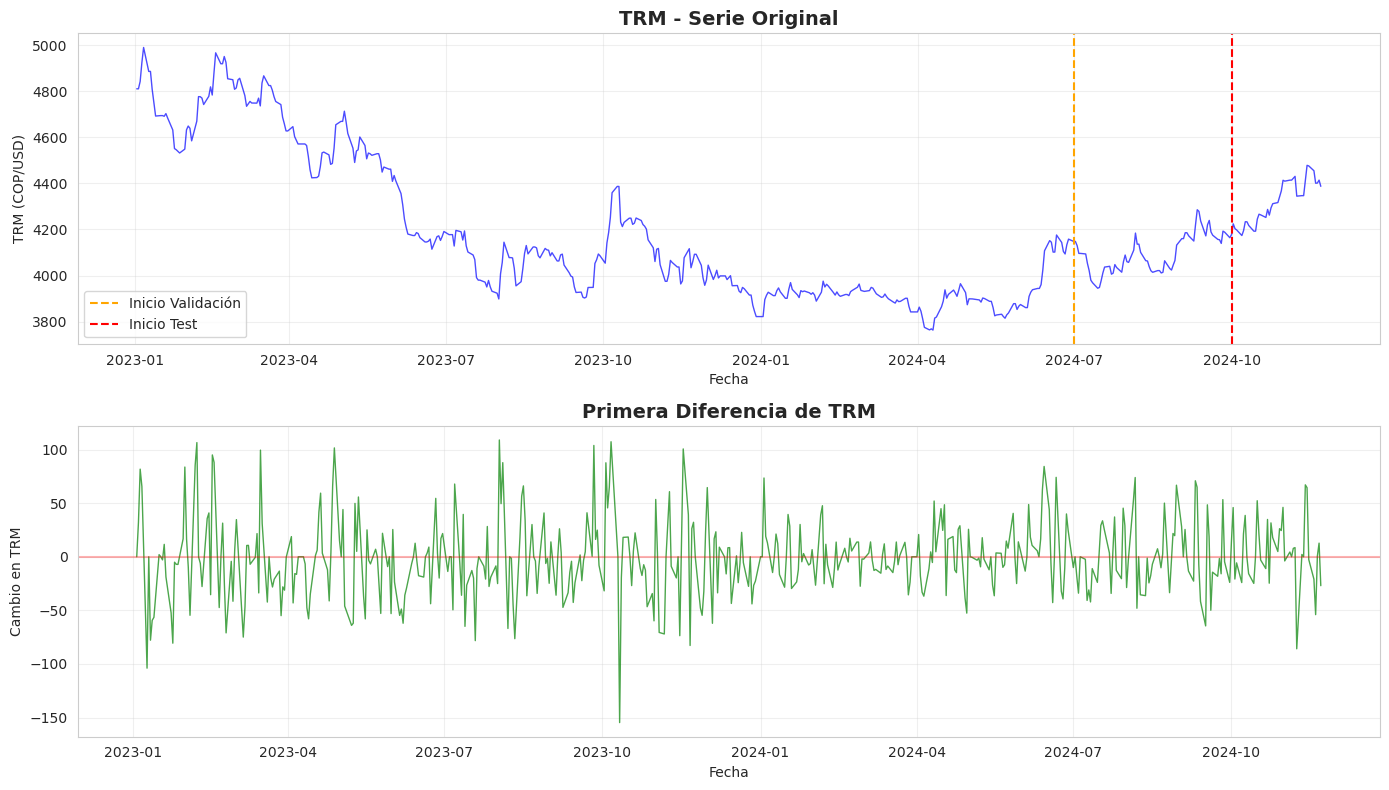

  Observaciones sobre la serie:
   - Volatilidad de primera diferencia: 35.68
   - ¿Hay tendencia visible? trm
   - ¿La volatilidad es constante? primera diferencia


In [40]:
# Visualizar serie original
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# Serie original
ax = axes[0]
ax.plot(df.index, df['trm'], color='blue', alpha=0.7, linewidth=1)
ax.set_title('TRM - Serie Original', fontsize=14, fontweight='bold')
ax.set_xlabel('Fecha')
ax.set_ylabel('TRM (COP/USD)')
ax.grid(True, alpha=0.3)

# Agregar líneas de división para train/val/test
ax.axvline(pd.Timestamp(CONFIG['fecha_inicio_val']), color='orange', linestyle='--', label='Inicio Validación')
ax.axvline(pd.Timestamp(CONFIG['fecha_inicio_test']), color='red', linestyle='--', label='Inicio Test')
ax.legend()

# Primera diferencia
ax = axes[1]
primera_dif = df['trm'].diff().dropna()
ax.plot(primera_dif.index, primera_dif, color='green', alpha=0.7, linewidth=1)
ax.set_title('Primera Diferencia de TRM', fontsize=14, fontweight='bold')
ax.set_xlabel('Fecha')
ax.set_ylabel('Cambio en TRM')
ax.axhline(y=0, color='red', linestyle='-', alpha=0.3)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"  Observaciones sobre la serie:")
print(f"   - Volatilidad de primera diferencia: {primera_dif.std():.2f}")
print(f"   - ¿Hay tendencia visible? trm")
print(f"   - ¿La volatilidad es constante? primera diferencia")

## 3. Transformaciones y División de Datos

### 3.1 Funciones de Transformación

In [41]:
def preparar_transformaciones(df, transformacion='retorno_log'):
    """
    Aplica la transformación especificada a los datos.
    
    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame con columna 'trm'
    transformacion : str
        Tipo de transformación: 'diferencia' o 'retorno_log'
    
    Returns:
    --------
    tuple
        (serie_transformada, función_inversa)
    """
    if transformacion == 'diferencia':
        serie_transformada = df['trm'].diff().dropna()
        ultimo_valor_conocido = df['trm'].iloc[-1]
        
        def inversa(prediccion_dif):
            return ultimo_valor_conocido + prediccion_dif
            
    elif transformacion == 'retorno_log':
        serie_transformada = np.log(df['trm'] / df['trm'].shift(1)).dropna()
        ultimo_valor_conocido = df['trm'].iloc[-1]
        
        def inversa(prediccion_ret):
            return ultimo_valor_conocido * np.exp(prediccion_ret)
    else:
        raise ValueError(f"Transformación no reconocida: {transformacion}")
    
    return serie_transformada, inversa

def dividir_datos(df, fecha_inicio_val, fecha_inicio_test):
    """
    Divide los datos en train, validación y test.
    """
    train = df[df.index < fecha_inicio_val]
    val = df[(df.index >= fecha_inicio_val) & (df.index < fecha_inicio_test)]
    test = df[df.index >= fecha_inicio_test]
    
    return train, val, test

### 3.2 Aplicar Transformaciones y División

In [42]:
# Dividir datos
train, val, test = dividir_datos(
    df,
    CONFIG['fecha_inicio_val'],
    CONFIG['fecha_inicio_test']
)

print(" División de datos:")
print(f"   Train: {len(train)} días ({train.index[0].date()} a {train.index[-1].date()})")
print(f"   Val:   {len(val)} días ({val.index[0].date()} a {val.index[-1].date()})")
print(f"   Test:  {len(test)} días ({test.index[0].date()} a {test.index[-1].date()})")

# Aplicar transformaciones
serie_trans_train, _ = preparar_transformaciones(train, CONFIG['transformacion'])
serie_trans_val, _ = preparar_transformaciones(val, CONFIG['transformacion'])
serie_trans_test, _ = preparar_transformaciones(test, CONFIG['transformacion'])

print(f"\n Estadísticas de {CONFIG['transformacion']}:")
print(f"   Train - Media: {serie_trans_train.mean():.6f}, Std: {serie_trans_train.std():.6f}")
print(f"   Val   - Media: {serie_trans_val.mean():.6f}, Std: {serie_trans_val.std():.6f}")
print(f"   Test  - Media: {serie_trans_test.mean():.6f}, Std: {serie_trans_test.std():.6f}")

 División de datos:
   Train: 390 días (2023-01-02 a 2024-06-28)
   Val:   66 días (2024-07-01 a 2024-09-30)
   Test:  39 días (2024-10-01 a 2024-11-22)

 Estadísticas de retorno_log:
   Train - Media: -0.000374, Std: 0.008595
   Val   - Media: 0.000060, Std: 0.007796
   Test  - Media: 0.001283, Std: 0.007100


### 3.3 Comparar Ambas Transformaciones

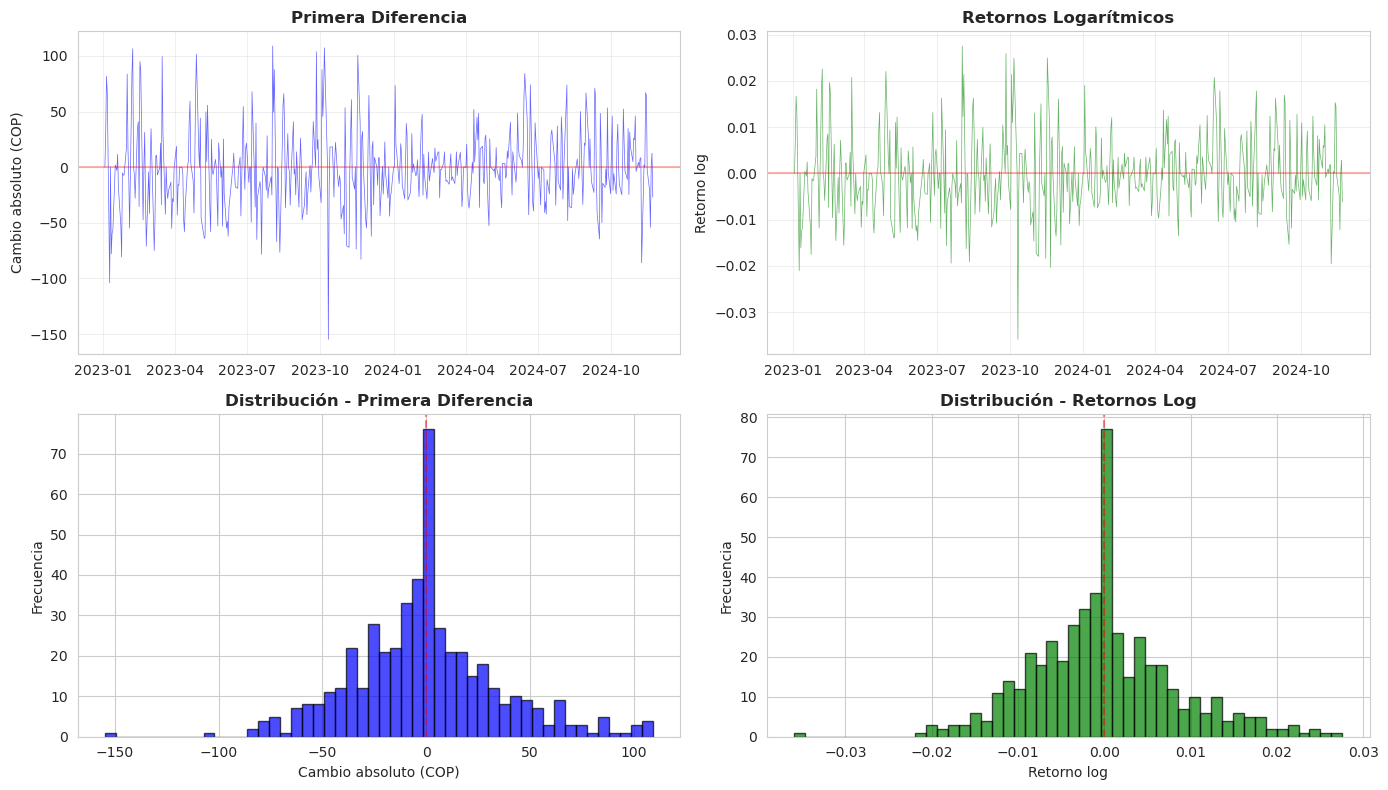

 Comparación de transformaciones:

Primera Diferencia:
  Skewness: 0.266
  Kurtosis: 1.190
  Test Normalidad (p-value): 0.0000

Retornos Logarítmicos:
  Skewness: 0.284
  Kurtosis: 1.055
  Test Normalidad (p-value): 0.0000

 Interpretación:
  - Valores cercanos a 0 en skewness = distribución simétrica
  - Kurtosis > 0 = colas pesadas (eventos extremos más frecuentes)
  - p-value < 0.05 = rechazar normalidad


In [43]:
# Comparar visualmente ambas transformaciones
fig, axes = plt.subplots(2, 2, figsize=(14, 8))

# Primera diferencia
ax = axes[0, 0]
primera_dif = df['trm'].diff().dropna()
ax.plot(primera_dif.index, primera_dif, color='blue', alpha=0.6, linewidth=0.5)
ax.set_title('Primera Diferencia', fontweight='bold')
ax.set_ylabel('Cambio absoluto (COP)')
ax.axhline(y=0, color='red', linestyle='-', alpha=0.3)
ax.grid(True, alpha=0.3)

# Retornos logarítmicos
ax = axes[0, 1]
retornos_log = np.log(df['trm'] / df['trm'].shift(1)).dropna()
ax.plot(retornos_log.index, retornos_log, color='green', alpha=0.6, linewidth=0.5)
ax.set_title('Retornos Logarítmicos', fontweight='bold')
ax.set_ylabel('Retorno log')
ax.axhline(y=0, color='red', linestyle='-', alpha=0.3)
ax.grid(True, alpha=0.3)

# Histogramas
ax = axes[1, 0]
ax.hist(primera_dif, bins=50, alpha=0.7, color='blue', edgecolor='black')
ax.set_title('Distribución - Primera Diferencia', fontweight='bold')
ax.set_xlabel('Cambio absoluto (COP)')
ax.set_ylabel('Frecuencia')
ax.axvline(x=0, color='red', linestyle='--', alpha=0.5)

ax = axes[1, 1]
ax.hist(retornos_log, bins=50, alpha=0.7, color='green', edgecolor='black')
ax.set_title('Distribución - Retornos Log', fontweight='bold')
ax.set_xlabel('Retorno log')
ax.set_ylabel('Frecuencia')
ax.axvline(x=0, color='red', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

# Estadísticas comparativas
from scipy import stats

print(" Comparación de transformaciones:")
print("\nPrimera Diferencia:")
print(f"  Skewness: {stats.skew(primera_dif):.3f}")
print(f"  Kurtosis: {stats.kurtosis(primera_dif):.3f}")
print(f"  Test Normalidad (p-value): {stats.jarque_bera(primera_dif)[1]:.4f}")

print("\nRetornos Logarítmicos:")
print(f"  Skewness: {stats.skew(retornos_log):.3f}")
print(f"  Kurtosis: {stats.kurtosis(retornos_log):.3f}")
print(f"  Test Normalidad (p-value): {stats.jarque_bera(retornos_log)[1]:.4f}")

print("\n Interpretación:")
print("  - Valores cercanos a 0 en skewness = distribución simétrica")
print("  - Kurtosis > 0 = colas pesadas (eventos extremos más frecuentes)")
print("  - p-value < 0.05 = rechazar normalidad")

## 4. Modelos Base

### 4.1 Random Walk con Drift (Baseline)

In [44]:
class RandomWalkDrift:
    """Baseline: Random Walk con Drift"""
    
    def __init__(self):
        self.drift = 0
        self.ultimo_valor = 0
        
    def fit(self, serie):
        """Calcula el drift promedio"""
        self.drift = serie.diff().mean()
        self.ultimo_valor = serie.iloc[-1]
        return self
        
    def predict(self, steps=1):
        """Predice usando último valor + drift"""
        if steps == 1:
            return self.ultimo_valor + self.drift
        else:
            predicciones = []
            valor_actual = self.ultimo_valor
            for _ in range(steps):
                valor_actual += self.drift
                predicciones.append(valor_actual)
            return np.array(predicciones)
    
    def update(self, nuevo_valor):
        """Actualiza el último valor conocido"""
        self.ultimo_valor = nuevo_valor

# Probar Random Walk
print("Entrenando Random Walk con Drift...")
rw_model = RandomWalkDrift()
rw_model.fit(serie_trans_train)
print(f"   Drift calculado: {rw_model.drift:.6f}")
print(f"   Último valor de entrenamiento: {rw_model.ultimo_valor:.6f}")

# Predicción de ejemplo
pred_rw = rw_model.predict(steps=5)
print(f"\n   Predicciones próximos 5 días: {pred_rw}")

Entrenando Random Walk con Drift...
   Drift calculado: 0.000015
   Último valor de entrenamiento: 0.005907

   Predicciones próximos 5 días: [0.00592235 0.00593757 0.0059528  0.00596802 0.00598324]


### 4.2 Auto-ARIMA

In [45]:
class ARIMAWrapper:
    """Wrapper para Auto-ARIMA con funcionalidad adicional"""
    
    def __init__(self, seasonal=False, max_p=5, max_q=5):
        self.seasonal = seasonal
        self.max_p = max_p
        self.max_q = max_q
        self.model = None
        self.order = None
        
    def fit(self, serie):
        """Entrena Auto-ARIMA"""
        print(f"   Buscando mejor modelo ARIMA (puede tomar un momento)...")
        
        self.model = auto_arima(
            serie,
            start_p=0, start_q=0,
            max_p=self.max_p, max_q=self.max_q,
            seasonal=self.seasonal,
            stepwise=True,
            suppress_warnings=True,
            error_action='ignore',
            trace=False  # Cambiar a True para ver proceso
        )
        
        self.order = self.model.order
        return self
    
    def predict(self, steps=1):
        """Predice n pasos adelante"""
        return self.model.predict(n_periods=steps)
    
    def update(self, nueva_observacion):
        """Actualiza el modelo con nueva observación"""
        self.model.update(nueva_observacion)
    
    def get_diagnostics(self):
        """Retorna diagnósticos del modelo"""
        return {
            'order': self.order,
            'aic': self.model.aic(),
            'bic': self.model.bic(),
            'summary': self.model.summary()
        }

In [46]:
# Entrenar ARIMA
print("Entrenando Auto-ARIMA...")
arima_model = ARIMAWrapper(seasonal=False, max_p=3, max_q=3)
arima_model.fit(serie_trans_train)

# Mostrar resultados
diagnostics = arima_model.get_diagnostics()
print(f"\nMejor modelo encontrado: ARIMA{diagnostics['order']}")
print(f"   AIC: {diagnostics['aic']:.2f}")
print(f"   BIC: {diagnostics['bic']:.2f}")

# Interpretar el orden
p, d, q = diagnostics['order']
print("\n Interpretación del modelo:")
if p == 0 and q == 0 and d == 1:
    print("   ARIMA(0,1,0) = Random Walk puro")
    print("   → La serie es casi completamente aleatoria")
elif p == 0 and d == 1 and q == 1:
    print("   ARIMA(0,1,1) = Suavizamiento exponencial simple")
    print("   → Hay autocorrelación en los errores")
elif p == 1 and d == 1 and q == 0:
    print("   ARIMA(1,1,0) = AR(1) con diferenciación")
    print("   → Existe dependencia del valor anterior")
else:
    print(f"   Modelo con {p} términos AR, {d} diferenciaciones, {q} términos MA")
    print("   → Estructura más compleja detectada")

# Mostrar resumen completo
print("\n" + "="*60)
print(diagnostics['summary'])

Entrenando Auto-ARIMA...
   Buscando mejor modelo ARIMA (puede tomar un momento)...

Mejor modelo encontrado: ARIMA(0, 0, 1)
   AIC: -2611.78
   BIC: -2603.86

 Interpretación del modelo:
   Modelo con 0 términos AR, 0 diferenciaciones, 1 términos MA
   → Estructura más compleja detectada

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  389
Model:               SARIMAX(0, 0, 1)   Log Likelihood                1307.892
Date:                Sun, 23 Nov 2025   AIC                          -2611.785
Time:                        16:23:59   BIC                          -2603.858
Sample:                    01-03-2023   HQIC                         -2608.642
                         - 06-28-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975

## 5. Métricas de Evaluación

In [47]:
def calcular_metricas(y_true, y_pred, prefijo=""):
    """Calcula conjunto completo de métricas de forma robusta."""
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)

    # Aplanar por si llegan 2D; manejar caso extraño (n,0)
    if y_true.ndim > 1:
        y_true = y_true.reshape(-1)
    if y_pred.ndim > 1:
        y_pred = y_pred.reshape(y_pred.shape[0], -1)
        if y_pred.shape[1] == 0:
            y_pred = np.array([])  # sin columnas -> vacío 1D
        else:
            y_pred = y_pred.reshape(-1)

    # Quitar NaNs y alinear longitudes
    n = min(len(y_true), len(y_pred))
    y_true = y_true[:n]
    y_pred = y_pred[:n]
    mask = (~np.isnan(y_true)) & (~np.isnan(y_pred))
    y_true = y_true[mask]
    y_pred = y_pred[mask]

    if len(y_true) == 0:
        return {
            f"{prefijo}mse": np.nan,
            f"{prefijo}rmse": np.nan,
            f"{prefijo}mae": np.nan,
            f"{prefijo}mape": np.nan,
            f"{prefijo}direccion_correcta": np.nan,
            f"{prefijo}max_error": np.nan,
            f"{prefijo}percentil_95_error": np.nan,
        }

    if len(y_true) > 1:
        cambios_true = np.diff(y_true)
        cambios_pred = np.diff(y_pred)
        # Re-alinear por si por redondeos dif longitudes tras diff
        m = min(len(cambios_true), len(cambios_pred))
        direccion_correcta = np.mean(
            np.sign(cambios_true[:m]) == np.sign(cambios_pred[:m])
        ) * 100
    else:
        direccion_correcta = np.nan

    metricas = {
        f"{prefijo}mse": mean_squared_error(y_true, y_pred),
        f"{prefijo}rmse": np.sqrt(mean_squared_error(y_true, y_pred)),
        f"{prefijo}mae": mean_absolute_error(y_true, y_pred),
        f"{prefijo}mape": np.mean(np.abs((y_true - y_pred) / (y_true + 1e-10))) * 100,
        f"{prefijo}direccion_correcta": direccion_correcta,
        f"{prefijo}max_error": np.max(np.abs(y_true - y_pred)),
        f"{prefijo}percentil_95_error": np.percentile(np.abs(y_true - y_pred), 95),
    }
    return metricas

print("Función de métricas definida")

Función de métricas definida


## 6. Backtesting con Re-entrenamiento Expansivo

Esta es la parte más importante: simular condiciones reales de predicción.

In [48]:
def backtest_expansivo(modelo_class, serie_completa, fecha_inicio_test, 
                       transformacion='retorno_log', verbose=True):
    """
    Realiza backtesting con re-entrenamiento expansivo.
    Simula condiciones reales donde re-entrenamos el modelo cada día.
    """
    # Preparar datos
    serie_test = serie_completa[serie_completa.index >= fecha_inicio_test]
    
    # Transformar toda la serie
    serie_trans, func_inversa = preparar_transformaciones(
        pd.DataFrame({'trm': serie_completa}), 
        transformacion
    )
    
    predicciones_trans = []
    predicciones_nivel = []
    reales_trans = []
    reales_nivel = []
    
    if verbose:
        print(f"\n Backtesting expansivo para {modelo_class.__name__}...")
        print(f"   Días a evaluar: {len(serie_test)-1}")
    
    for i, (fecha, valor_real) in enumerate(serie_test.iloc[1:].items()):
        datos_hasta_ayer = serie_completa[:fecha].iloc[:-1]
        datos_trans_hasta_ayer = serie_trans[:fecha].iloc[:-1]
        
        modelo = modelo_class()
        modelo.fit(datos_trans_hasta_ayer)

        # Predicción robusta -> escalar o NaN
        try:
            pred_trans = modelo.predict(steps=1)
            pred_vec = np.asarray(pred_trans).reshape(-1)
            pred_trans = float(pred_vec[0]) if pred_vec.size > 0 else np.nan
        except Exception as e:
            if verbose:
                print(f"   Aviso: predicción inválida en {fecha.date()}: {e}")
            pred_trans = np.nan
        
        # Convertir a nivel (propaga NaN si aplica)
        ultimo_valor = datos_hasta_ayer.iloc[-1]
        if transformacion == 'diferencia':
            pred_nivel = ultimo_valor + pred_trans
        else:  # retorno_log
            pred_nivel = ultimo_valor * np.exp(pred_trans) if np.isfinite(pred_trans) else np.nan
        
        # Guardar
        predicciones_trans.append(pred_trans)
        predicciones_nivel.append(pred_nivel)
        
        # Real transformado
        if transformacion == 'diferencia':
            real_trans = valor_real - ultimo_valor
        else:
            real_trans = np.log(valor_real / ultimo_valor)
        
        reales_trans.append(real_trans)
        reales_nivel.append(valor_real)
        
        if verbose and (i+1) % 10 == 0:
            print(f"   Procesados {i+1}/{len(serie_test)-1} días")
    
    # Métricas (función ya alinea y limpia)
    metricas_trans = calcular_metricas(
        np.array(reales_trans), 
        np.array(predicciones_trans),
        prefijo="trans_"
    )
    metricas_nivel = calcular_metricas(
        np.array(reales_nivel),
        np.array(predicciones_nivel),
        prefijo="nivel_"
    )
    return {**metricas_trans, **metricas_nivel}, predicciones_nivel, reales_nivel

print(" Función de backtesting definida")
# ...existing code...

 Función de backtesting definida


## 7. Ejecutar Experimento Completo

In [49]:
# Ejecutar backtesting para Random Walk
print("="*60)
print("EXPERIMENTO: RANDOM WALK CON DRIFT")
print("="*60)

metricas_rw, pred_rw, real_rw = backtest_expansivo(
    RandomWalkDrift,
    df['trm'],
    CONFIG['fecha_inicio_test'],
    transformacion=CONFIG['transformacion']
)

print("\n Resultados Random Walk:")
print(f"   MSE (transformado): {metricas_rw['trans_mse']:.6f}")
print(f"   MSE (niveles TRM): {metricas_rw['nivel_mse']:.2f}")
print(f"   MAE (niveles TRM): {metricas_rw['nivel_mae']:.2f}")
print(f"   Dirección correcta: {metricas_rw['nivel_direccion_correcta']:.1f}%")
print(f"   Error máximo: {metricas_rw['nivel_max_error']:.2f} COP")

EXPERIMENTO: RANDOM WALK CON DRIFT

 Backtesting expansivo para RandomWalkDrift...
   Días a evaluar: 38
   Procesados 10/38 días
   Procesados 20/38 días
   Procesados 30/38 días

 Resultados Random Walk:
   MSE (transformado): 0.000084
   MSE (niveles TRM): 1573.67
   MAE (niveles TRM): 31.18
   Dirección correcta: 45.9%
   Error máximo: 94.42 COP


In [50]:
# Ejecutar backtesting para ARIMA
print("="*60)
print("EXPERIMENTO: AUTO-ARIMA")
print("="*60)

metricas_ar, pred_ar, real_ar = backtest_expansivo(
    ARIMAWrapper,
    df['trm'],
    CONFIG['fecha_inicio_test'],
    transformacion=CONFIG['transformacion']
)

print("\nResultados ARIMA:")
print(f"   MSE (transformado): {metricas_ar['trans_mse']:.6f}")
print(f"   MSE (niveles TRM): {metricas_ar['nivel_mse']:.2f}")
print(f"   MAE (niveles TRM): {metricas_ar['nivel_mae']:.2f}")
print(f"   Dirección correcta: {metricas_ar['nivel_direccion_correcta']:.1f}%")
print(f"   Error máximo: {metricas_ar['nivel_max_error']:.2f} COP")

EXPERIMENTO: AUTO-ARIMA

 Backtesting expansivo para ARIMAWrapper...
   Días a evaluar: 38
   Buscando mejor modelo ARIMA (puede tomar un momento)...
   Buscando mejor modelo ARIMA (puede tomar un momento)...
   Buscando mejor modelo ARIMA (puede tomar un momento)...
   Buscando mejor modelo ARIMA (puede tomar un momento)...
   Buscando mejor modelo ARIMA (puede tomar un momento)...
   Buscando mejor modelo ARIMA (puede tomar un momento)...
   Buscando mejor modelo ARIMA (puede tomar un momento)...
   Buscando mejor modelo ARIMA (puede tomar un momento)...
   Buscando mejor modelo ARIMA (puede tomar un momento)...
   Buscando mejor modelo ARIMA (puede tomar un momento)...
   Procesados 10/38 días
   Buscando mejor modelo ARIMA (puede tomar un momento)...
   Buscando mejor modelo ARIMA (puede tomar un momento)...
   Buscando mejor modelo ARIMA (puede tomar un momento)...
   Buscando mejor modelo ARIMA (puede tomar un momento)...
   Buscando mejor modelo ARIMA (puede tomar un momento)...

## 8. Comparación y Visualización de Resultados

In [51]:
# Comparación directa
print("="*60)
print("COMPARACIÓN DE MODELOS")
print("="*60)

mejora_mse = (1 - metricas_ar['nivel_mse'] / metricas_rw['nivel_mse']) * 100
mejora_mae = (1 - metricas_ar['nivel_mae'] / metricas_rw['nivel_mae']) * 100

print(f"\n ARIMA vs Random Walk:")
if mejora_mse > 0:
    print(f"    ARIMA mejora MSE en {mejora_mse:.1f}%")
else:
    print(f"    Random Walk supera a ARIMA en MSE por {-mejora_mse:.1f}%")
    print(f"      → Posible indicador de mercado eficiente")

if mejora_mae > 0:
    print(f"    ARIMA mejora MAE en {mejora_mae:.1f}%")
else:
    print(f"    Random Walk supera a ARIMA en MAE por {-mejora_mae:.1f}%")

# Análisis de dirección
print(f"\n Análisis de dirección:")
if metricas_ar['nivel_direccion_correcta'] > 55:
    print(f"    ARIMA predice dirección correctamente {metricas_ar['nivel_direccion_correcta']:.1f}% del tiempo")
    print(f"      → Hay estructura predictible")
elif metricas_ar['nivel_direccion_correcta'] > 50:
    print(f"    ARIMA predice dirección {metricas_ar['nivel_direccion_correcta']:.1f}% del tiempo")
    print(f"      → Mejora marginal sobre aleatorio")
else:
    print(f"    ARIMA predice dirección solo {metricas_ar['nivel_direccion_correcta']:.1f}% del tiempo")
    print(f"      → No mejor que lanzar una moneda")

COMPARACIÓN DE MODELOS

 ARIMA vs Random Walk:
    ARIMA mejora MSE en 40.4%
    ARIMA mejora MAE en 24.4%

 Análisis de dirección:
    ARIMA predice dirección solo 45.9% del tiempo
      → No mejor que lanzar una moneda


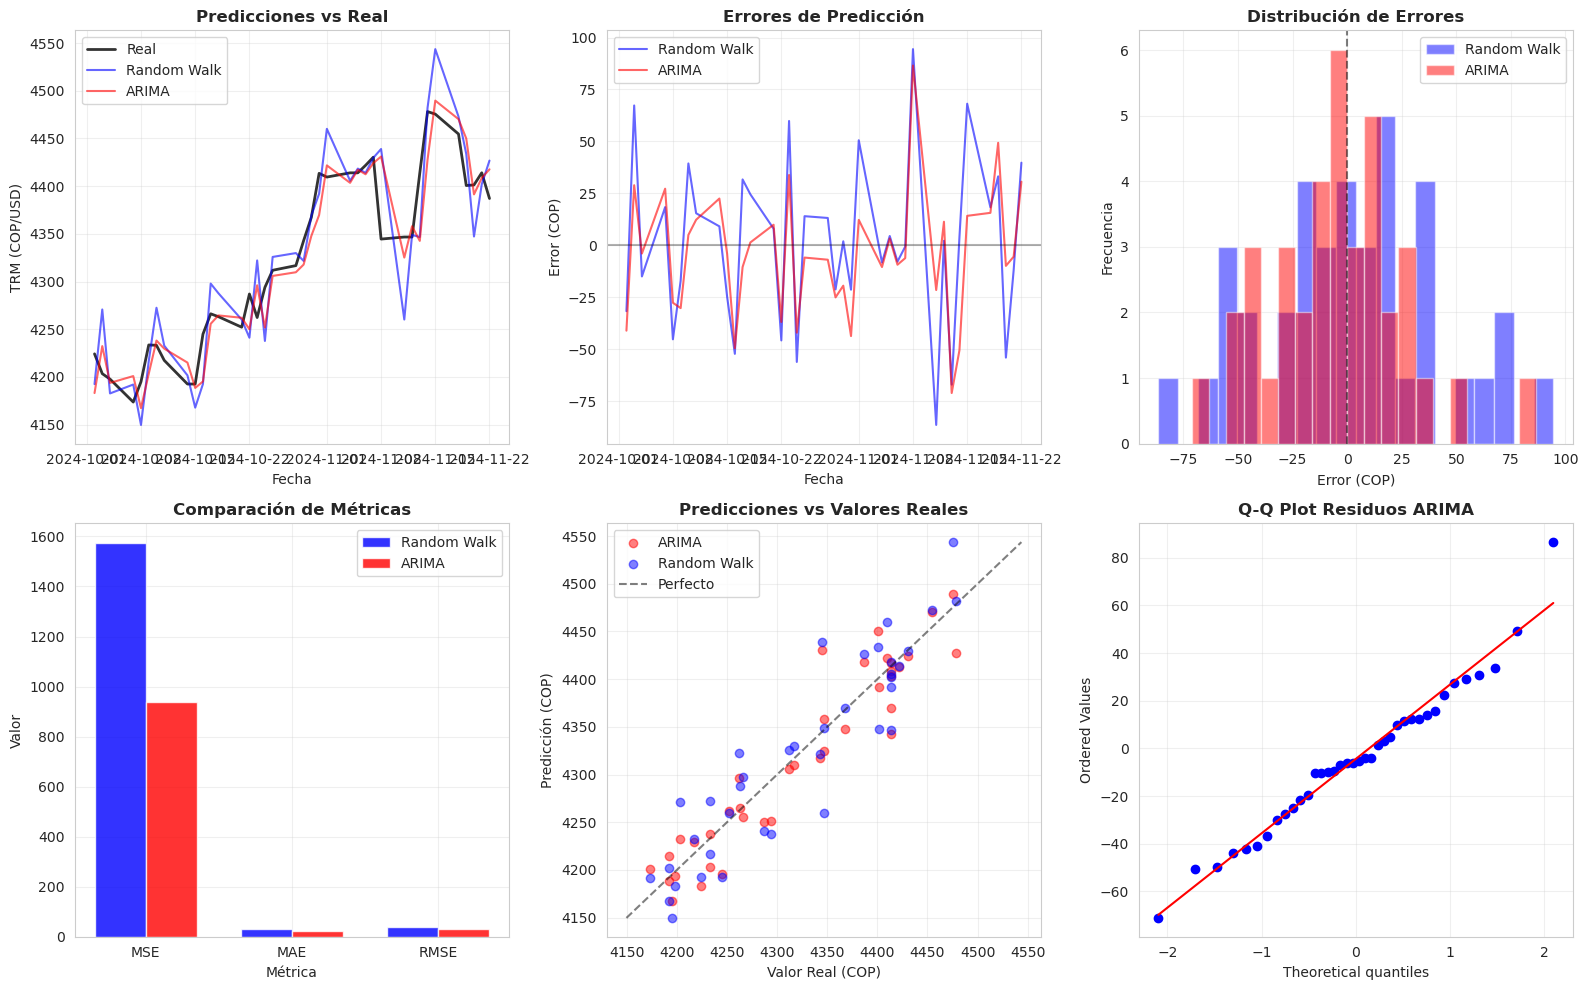


 Visualizaciones generadas y guardadas como 'resultados_trm_completo.png'


In [52]:
# Visualización comprehensiva
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

# 1. Series temporales de predicciones
ax = axes[0, 0]
fechas_test = df[df.index >= CONFIG['fecha_inicio_test']].index[1:]
ax.plot(fechas_test, real_ar, label='Real', color='black', linewidth=2, alpha=0.8)
ax.plot(fechas_test, pred_rw, label='Random Walk', color='blue', alpha=0.6)
ax.plot(fechas_test, pred_ar, label='ARIMA', color='red', alpha=0.6)
ax.set_title('Predicciones vs Real', fontsize=12, fontweight='bold')
ax.set_xlabel('Fecha')
ax.set_ylabel('TRM (COP/USD)')
ax.legend()
ax.grid(True, alpha=0.3)

# 2. Errores a lo largo del tiempo
ax = axes[0, 1]
errores_rw = np.array(pred_rw) - np.array(real_rw)
errores_ar = np.array(pred_ar) - np.array(real_ar)
ax.plot(fechas_test, errores_rw, label='Random Walk', color='blue', alpha=0.6)
ax.plot(fechas_test, errores_ar, label='ARIMA', color='red', alpha=0.6)
ax.axhline(y=0, color='black', linestyle='-', alpha=0.3)
ax.set_title('Errores de Predicción', fontsize=12, fontweight='bold')
ax.set_xlabel('Fecha')
ax.set_ylabel('Error (COP)')
ax.legend()
ax.grid(True, alpha=0.3)

# 3. Distribución de errores
ax = axes[0, 2]
ax.hist(errores_rw, bins=20, alpha=0.5, label='Random Walk', color='blue')
ax.hist(errores_ar, bins=20, alpha=0.5, label='ARIMA', color='red')
ax.set_title('Distribución de Errores', fontsize=12, fontweight='bold')
ax.set_xlabel('Error (COP)')
ax.set_ylabel('Frecuencia')
ax.axvline(x=0, color='black', linestyle='--', alpha=0.5)
ax.legend()
ax.grid(True, alpha=0.3)

# 4. Comparación de métricas
ax = axes[1, 0]
metricas_nombres = ['MSE', 'MAE', 'RMSE']
metricas_rw_vals = [metricas_rw['nivel_mse'], metricas_rw['nivel_mae'], 
                    np.sqrt(metricas_rw['nivel_mse'])]
metricas_ar_vals = [metricas_ar['nivel_mse'], metricas_ar['nivel_mae'], 
                    np.sqrt(metricas_ar['nivel_mse'])]

x = np.arange(len(metricas_nombres))
width = 0.35
ax.bar(x - width/2, metricas_rw_vals, width, label='Random Walk', alpha=0.8, color='blue')
ax.bar(x + width/2, metricas_ar_vals, width, label='ARIMA', alpha=0.8, color='red')
ax.set_xlabel('Métrica')
ax.set_ylabel('Valor')
ax.set_title('Comparación de Métricas', fontsize=12, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(metricas_nombres)
ax.legend()
ax.grid(True, alpha=0.3)

# 5. Scatter plot: Predicciones vs Real
ax = axes[1, 1]
ax.scatter(real_ar, pred_ar, alpha=0.5, color='red', label='ARIMA')
ax.scatter(real_rw, pred_rw, alpha=0.5, color='blue', label='Random Walk')
min_val = min(min(real_ar), min(pred_ar), min(pred_rw))
max_val = max(max(real_ar), max(pred_ar), max(pred_rw))
ax.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.5, label='Perfecto')
ax.set_xlabel('Valor Real (COP)')
ax.set_ylabel('Predicción (COP)')
ax.set_title('Predicciones vs Valores Reales', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# 6. Análisis de residuos ARIMA
ax = axes[1, 2]
from scipy import stats
stats.probplot(errores_ar, dist="norm", plot=ax)
ax.set_title('Q-Q Plot Residuos ARIMA', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('resultados_trm_completo.png', dpi=100, bbox_inches='tight')
plt.show()

print("\n Visualizaciones generadas y guardadas como 'resultados_trm_completo.png'")

## 9. Conclusiones y Próximos Pasos

### 9.1 Resumen de Hallazgos

In [55]:
print("="*60)
print("RESUMEN EJECUTIVO")
print("="*60)

print("\n Configuración del experimento:")
print(f"   - Transformación: {CONFIG['transformacion']}")
print(f"   - Período de test: {CONFIG['fecha_inicio_test']} en adelante")
print(f"   - Días evaluados: {len(real_ar)}")

print("\n Mejor modelo:")
if metricas_ar['nivel_mse'] < metricas_rw['nivel_mse']:
    print(f"   ARIMA con MSE = {metricas_ar['nivel_mse']:.2f}")
else:
    print(f"   Random Walk con MSE = {metricas_rw['nivel_mse']:.2f}")
    print("    Nota: Si Random Walk es mejor, sugiere mercado eficiente")

print("\n Insights clave:")
print(f"   1. Error promedio diario: {metricas_ar['nivel_mae']:.2f} COP")
print(f"   2. Error máximo observado: {metricas_ar['nivel_max_error']:.2f} COP")
print(f"   3. Predicción de dirección: {metricas_ar['nivel_direccion_correcta']:.1f}%")

print("\n Recomendaciones:")
if mejora_mse > 5:
    print("    ARIMA muestra mejora significativa - proceder con modelos más complejos")
    print("   → Siguiente paso: Implementar LSTM e híbridos")
elif mejora_mse > 0:
    print("    ARIMA muestra mejora marginal - evaluar costo/beneficio de modelos complejos")
    print("   → Siguiente paso: Optimizar hiperparámetros de ARIMA primero")
else:
    print("    Random Walk es suficiente - mercado aparentemente eficiente")
    print("   → Siguiente paso: Buscar features externos (petróleo, tasas Fed, etc.)")

RESUMEN EJECUTIVO

 Configuración del experimento:
   - Transformación: retorno_log
   - Período de test: 2024-10-01 en adelante
   - Días evaluados: 38

 Mejor modelo:
   ARIMA con MSE = 938.13

 Insights clave:
   1. Error promedio diario: 23.58 COP
   2. Error máximo observado: 86.52 COP
   3. Predicción de dirección: 45.9%

 Recomendaciones:
    ARIMA muestra mejora significativa - proceder con modelos más complejos
   → Siguiente paso: Implementar LSTM e híbridos


### 9.2 Experimentos Adicionales Sugeridos

In [58]:
# Experimento: Comparar transformaciones
print("EXPERIMENTO ADICIONAL: Comparar Transformaciones\n")

for trans in ['diferencia', 'retorno_log']:
    print(f"Probando con {trans}...")
    metricas_temp, _, _ = backtest_expansivo(
        ARIMAWrapper,
        df['trm'],
        CONFIG['fecha_inicio_test'],
        transformacion=trans,
        verbose=False
    )
    print(f"  MSE (niveles): {metricas_temp['nivel_mse']:.2f}")
    print(f"  MAE (niveles): {metricas_temp['nivel_mae']:.2f}")
    print()

print(" La transformación con menor MSE en niveles es la más adecuada")

EXPERIMENTO ADICIONAL: Comparar Transformaciones

Probando con diferencia...
   Buscando mejor modelo ARIMA (puede tomar un momento)...
   Buscando mejor modelo ARIMA (puede tomar un momento)...
   Buscando mejor modelo ARIMA (puede tomar un momento)...
   Buscando mejor modelo ARIMA (puede tomar un momento)...
   Buscando mejor modelo ARIMA (puede tomar un momento)...
   Buscando mejor modelo ARIMA (puede tomar un momento)...
   Buscando mejor modelo ARIMA (puede tomar un momento)...
   Buscando mejor modelo ARIMA (puede tomar un momento)...
   Buscando mejor modelo ARIMA (puede tomar un momento)...
   Buscando mejor modelo ARIMA (puede tomar un momento)...
   Buscando mejor modelo ARIMA (puede tomar un momento)...
   Buscando mejor modelo ARIMA (puede tomar un momento)...
   Buscando mejor modelo ARIMA (puede tomar un momento)...
   Buscando mejor modelo ARIMA (puede tomar un momento)...
   Buscando mejor modelo ARIMA (puede tomar un momento)...
   Buscando mejor modelo ARIMA (puede 

### 9.3 Guardar Resultados

In [57]:
# Guardar resultados en un DataFrame
resultados_df = pd.DataFrame({
    'fecha': fechas_test,
    'real': real_ar,
    'pred_random_walk': pred_rw,
    'pred_arima': pred_ar,
    'error_random_walk': errores_rw,
    'error_arima': errores_ar
})

# Guardar a CSV
resultados_df.to_csv('resultados_experimento_trm.csv', index=False)
print(" Resultados guardados en 'resultados_experimento_trm.csv'")

# Mostrar resumen
print("\nPrimeras filas de resultados:")
display(resultados_df.head(10))

 Resultados guardados en 'resultados_experimento_trm.csv'

Primeras filas de resultados:


,fecha,real,pred_random_walk,pred_arima,error_random_walk,error_arima
0,2024-10-02,4224.21,4192.47,4183.09,-31.74,-41.12
1,2024-10-03,4203.43,4270.73,4232.33,67.30,28.90
2,2024-10-04,4197.73,4182.71,4193.74,-15.02,-3.99
3,2024-10-07,4173.66,4192.03,4200.89,18.37,27.23
4,2024-10-08,4194.97,4149.68,4167.29,-45.29,-27.68
5,2024-10-09,4233.54,4216.44,4203.27,-17.10,-30.27
6,2024-10-10,4233.17,4272.55,4238.14,39.38,4.97
7,2024-10-11,4217.40,4232.80,4229.67,15.40,12.27
8,2024-10-14,4192.56,4201.65,4215.05,9.09,22.49
9,2024-10-15,4192.56,4167.81,4188.49,-24.75,-4.07


## 10. Próximos Pasos

Con base en los resultados obtenidos:

1. **Si ARIMA supera al Random Walk:**
   - Proceder con LSTM e híbridos (usar el notebook de extensión)
   - Optimizar ventanas temporales
   - Agregar features macroeconómicos

2. **Si Random Walk es competitivo:**
   - Investigar features externos (petróleo, tasas de interés)
   - Considerar modelos de volatilidad (GARCH)
   - Evaluar si el objetivo debe ser predicción de volatilidad en lugar de precio

3. **Mejoras generales:**
   - Probar diferentes horizontes de predicción (5 días, 1 mes)
   - Implementar ensemble de modelos
   - Analizar errores en períodos específicos (¿cuándo falla el modelo?)